# Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## `SimpleEngine`

思いつきで最初に作ったEngine

n=9の時、すでに10秒くらいかかる。n=10の時、120秒ほど。

time conplexity は O(n!)

## `MinConflictsEngine` Version 1.0

min-conflicts heuristic を知って初めて作ったEngine

`SimpleEngine`よりもはるかに早く計算できるが、以下のように、計算時間にかなりばらつきがある

ぱっと見改善できそうなところ

* そもそもglobal solutionでない可能性がある。1000step経過してもずっと状態が変わらないことも多々あるようだ。
* [Stolving Large-Scale Constraint Satisfaction an Scheduling Problems Using a Repair Method](https://aaai.org/Papers/AAAI/1990/AAAI90-003.pdf) では、初期の状態を作るときにmin-conflictsを適用している。
* conflicts状態にある行をランダムにとっているが、修正したところに影響のある行をとってくる、というのもありか？
* BoardではなくQueenにlocationを持たせるとどうか？
* breaks tie randomly
* 各関数がどれくらい時間かかっているか計測しよう

In [2]:
from engine.minconflicts_engine import MinConflictsEngine

In [3]:
# describe
df = pd.read_csv('./analysis/MinConflictsEngine_result.csv')
df.describe()

,duration_seconds,steps
count,100.000000,100.000000
mean,23.550000,424.210000
std,42.134555,426.066654
min,0.000000,0.000000
25%,0.000000,88.250000
50%,4.000000,161.500000
75%,13.750000,1000.000000
max,166.000000,1000.000000


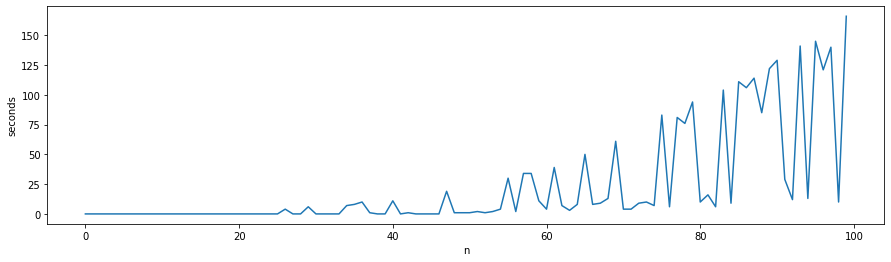

In [4]:
x = df.index
y = df['duration_seconds']
plt.figure(figsize=(15, 4))
plt.plot(x, y)
plt.xlabel('n')
plt.ylabel('seconds')
plt.show()

## `MinConflictsEngine` Version 2.0

Update from version 1.0

* 最初にBoardを作るときにもmin-conflictsを満たすように配置した
* Queenを動かすときに、1/100の確率でランダムに配置するようにした(break ties randomly)

気持ち安定したが、数が大きくなるとたいして変わらん

次のtry

* 論文にあるように、次のunitはconflictを起こしているものにする

In [5]:
# describe
df = pd.read_csv('./analysis/MinConflictsEngine_ver2_result.csv')
df.describe()

,duration_seconds,steps
count,100.000000,100.000000
mean,15.720000,233.980000
std,30.007433,292.069072
min,0.000000,0.000000
25%,0.000000,50.750000
50%,2.500000,96.000000
75%,14.250000,286.250000
max,146.000000,1000.000000


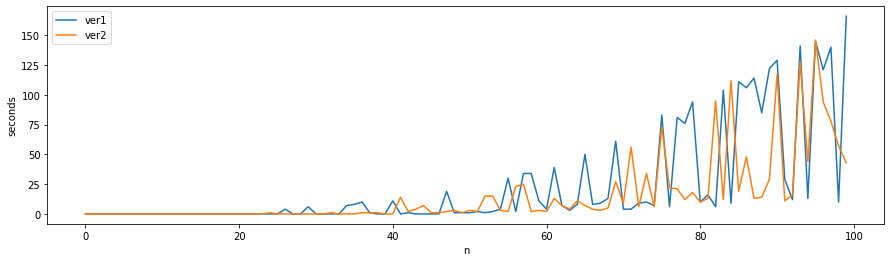

In [6]:
df_ver1 = pd.read_csv('./analysis/MinConflictsEngine_result.csv')
df_ver2 = pd.read_csv('./analysis/MinConflictsEngine_ver2_result.csv')
x = df_ver1.index
y1 = df_ver1['duration_seconds']
y2 = df_ver2['duration_seconds']
plt.figure(figsize=(15, 4))
plt.plot(x, y1, label='ver1')
plt.plot(x, y2, label='ver2')
plt.legend()
plt.xlabel('n')
plt.ylabel('seconds')
plt.show()

## `MinConflictsEngine` Version 3.0

Update from version 2.0

* 論文にあるように、次のunitはconflictを起こしているものにする

そもそも、各stepに時間がかかり過ぎている。n=1,000から10,000の間でようやく全体が1秒になるくらいだから、一つのstepに90msもかけてはいけない

またぶれが大きすぎる

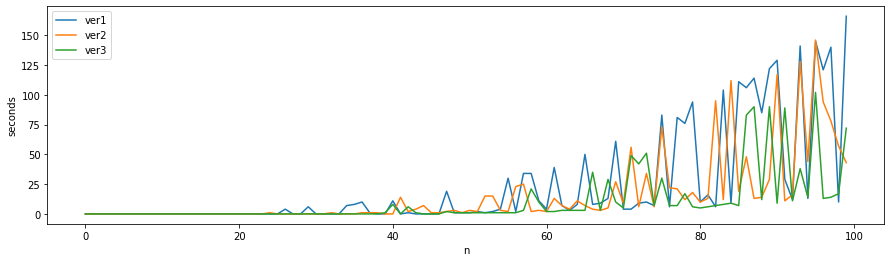

In [7]:
df_ver1 = pd.read_csv('./analysis/MinConflictsEngine_result.csv')
df_ver2 = pd.read_csv('./analysis/MinConflictsEngine_ver2_result.csv')
df_ver3 = pd.read_csv('./analysis/MinConflictsEngine_ver3_result.csv')
x = df_ver1.index
y1 = df_ver1['duration_seconds']
y2 = df_ver2['duration_seconds']
y3 = df_ver3['duration_seconds']
plt.figure(figsize=(15, 4))
plt.plot(x, y1, label='ver1')
plt.plot(x, y2, label='ver2')
plt.plot(x, y3, label='ver3')
plt.legend()
plt.xlabel('n')
plt.ylabel('seconds')
plt.show()

In [8]:
# 各stepでどれくらいの時間を費やしているのかをかくにんする
df_ver3_nonzerotime = df_ver3[df_ver3['duration_seconds'] != 0].copy()
df_ver3_nonzerotime.reset_index(drop=True, inplace=True)
ser = df_ver3_nonzerotime['duration_seconds'] / df_ver3_nonzerotime['steps']
ser.describe()

count    57.000000
mean      0.089243
std       0.071428
min       0.005747
25%       0.034483
50%       0.058824
75%       0.135338
max       0.250000
dtype: float64

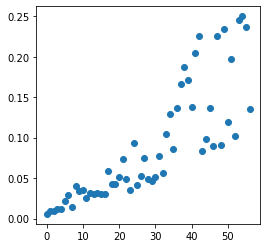

In [9]:
y = list(ser)
x = [i for i in range(len(y))]
plt.figure(figsize=(4, 4))
plt.scatter(x, y)

version 3で、各関数に費やしている時間を見ると、以下のようになっている

以下、n=50として計算

最も影響がでかいのは、`get_conflicts_count`。これが1秒以上かかっている。

`has_solution`も`search_next_unit`も、その内部に`get_conflicts_count`を含むので、この時間を圧倒的に小さくする必要がある

ちなみに、n=100にすると`get_conflicts_count`に1ms以上、たまに10ms, 12msかかる時があるので、圧倒的にだめだ。

```json
{
  "__init__": {
    "total_ms": 0.1,
    "count": 1,
    "ratio_per_count": 0.1
  },
  "break_ties_randomly": {
    "total_ms": 0.39900000000000024,
    "count": 77,
    "ratio_per_count": 0.005181818181818185
  },
  "choose_one_conflicts": {
    "total_ms": 17.380000000000003,
    "count": 27,
    "ratio_per_count": 0.6437037037037038
  },
  "convert_to_boards": {
    "total_ms": 0.327,
    "count": 1,
    "ratio_per_count": 0.327
  },
  "get_conflicts_count": {
    "total_ms": 1152.5489999999972,
    "count": 4015,
    "ratio_per_count": 0.287060772104607
  },
  "has_solution": {
    "total_ms": 59.718,
    "count": 29,
    "ratio_per_count": 2.059241379310345
  },
  "initialize_current_board": {
    "total_ms": 663.634,
    "count": 1,
    "ratio_per_count": 663.634
  },
  "move": {
    "total_ms": 0.1460000000000001,
    "count": 77,
    "ratio_per_count": 0.0018961038961038974
  },
  "search_next_unit": {
    "total_ms": 1105.8249999999998,
    "count": 77,
    "ratio_per_count": 14.361363636363635
  },
  "solve": {
    "total_ms": 1171.42,
    "count": 1,
    "ratio_per_count": 1171.42
  }
}
```


## `MinConflictsEngine` Version 3.1

update from version 3.0


* `get_conflicts_count`のtime complexityが`O(n^2)`になっていたので`O(n)`になるようにした

だいぶ早くなった

次のtry

* そもそもglobal solutionでない可能性がある。1000step経過してもずっと状態が変わらないことも多々あるようだ。-> break ties randomlyの頻度を大きくしてみる
* ここが最も注目すべき。論文を読むと、初期状態から10stepほどでできるようになったぽい。step数が確かに圧倒的に多いから、ここをケアしてみようか。本の中のCSPをきちんと読み解く。-> 明らかに初期状態おかしいみたいだ。以下の8-queenの時をみよ。

```
 |0|1|2|3|4|5|6|7|
------------------
0|Q| | | | | | | |
------------------
1| | |Q| | | | | |
------------------
2| | | | |Q| | | |
------------------
3| |Q| | | | | | |
------------------
4| | | |Q| | | | |
------------------
5|Q| | | | | | | |
------------------
6| | |Q| | | | | |
------------------
7| | | | |Q| | | |
------------------
```

* 各関数がどれくらい時間かかっているかもう一度計測しよう。
* conflictの計算を都度行うのは無駄かもしれない。queenを配置したり取り除くときに、その値は決まるものである。conflict_count_tableなるものを作ろうか。
* 汚くなってきたので、全面的に描き直すことも考えても良い。

In [10]:
from models.model import Engine
def benchmark(filename: str, start_num: int = 0, end_num: int = 100):
    filename = f'./analysis/{filename}'
    import datetime
    # start
    start_time = datetime.datetime.now()
    # measure how long solving problems take time with respect to n
    durations = []
    steps = []
    for n in range(start_num, end_num):
        print(f'n: {n}')
        e = MinConflictsEngine(n=n, version=3)
        _ = e.solve()
        durations.append(e.debug_duration_seconds)
        steps.append(e.debug_steps)
        print(f'duration_seconds: {durations[-1]}, steps: {steps[-1]}')
    # end
    end_time = datetime.datetime.now()
    # total duration
    print(f'total_duration_seconds: {(end_time - start_time).seconds}')
    # make DataFrame
    d = {'duration_seconds': durations, 'steps': steps}
    df = pd.DataFrame(d)
    df.to_csv(filename, index=None)

In [19]:
# benchmark('MinConflictsEngine_ver3_1_result.csv', start_num=0, end_num=100)

In [20]:
df_ver3_1 = pd.read_csv('./analysis/MinConflictsEngine_ver3_1_result.csv')
df_ver3_1.describe()

,duration_seconds,steps
count,100.000000,100.000000
mean,0.340000,174.650000
std,0.945163,257.907053
min,0.000000,0.000000
25%,0.000000,23.750000
50%,0.000000,49.000000
75%,0.000000,251.750000
max,5.000000,1000.000000


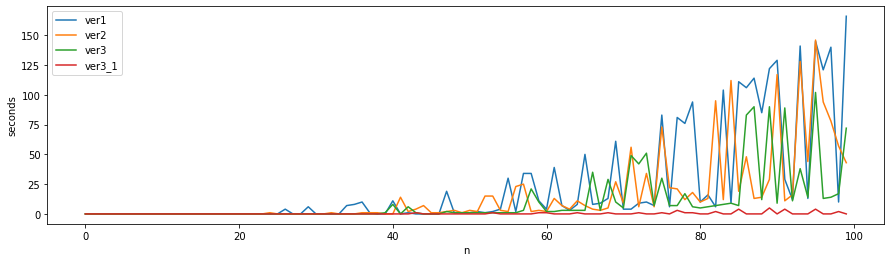

In [12]:
df_ver1 = pd.read_csv('./analysis/MinConflictsEngine_result.csv')
df_ver2 = pd.read_csv('./analysis/MinConflictsEngine_ver2_result.csv')
df_ver3 = pd.read_csv('./analysis/MinConflictsEngine_ver3_result.csv')
df_ver3_1 = pd.read_csv('./analysis/MinConflictsEngine_ver3_1_result.csv')
x = df_ver1.index
y1 = df_ver1['duration_seconds']
y2 = df_ver2['duration_seconds']
y3 = df_ver3['duration_seconds']
y3_1 = df_ver3_1['duration_seconds']
plt.figure(figsize=(15, 4))
plt.plot(x, y1, label='ver1')
plt.plot(x, y2, label='ver2')
plt.plot(x, y3, label='ver3')
plt.plot(x, y3_1, label='ver3_1')
plt.legend()
plt.xlabel('n')
plt.ylabel('seconds')
plt.show()

## `MinConflictsEngine` Version 4

update from version 3.1

* `choose_one_conflicts`のランダム性を無くした。システマティックにコンフリクトが生じているところだけ調査する。
* min-conflictで調査した後に移動する先を、min-conflictsとなっているitemの中からランダムに選択するようにした
* `initialize_current_board`にて、min-conflicts を使っていたが、行番号が小さい順番から選択するようになっていたので、それをランダムに選択するようにした
* conflictの数え方を、[wikipedia](https://en.wikipedia.org/wiki/Min-conflicts_algorithm)にあるように、同じ方向からattackする場合を重複して数え上げないようにした
* `break_ties_randomly`の確率調整

初期のboardについてAC-3も考えたが、AC-3をするための初期のboardの考え方がよくわからないし、そもそも論文の中でもmin-conflictsでやっているので、やめた

step数も圧倒的に安定した。100までは1秒以内にほぼブレもなく終わる

改善点

* `get_conflicts_count`の速度は0.13msとまあまあ速いものの、回数が多過ぎて、これで23秒かかっている。解決するまで24秒かかっているところから、ほぼこれで時間を食ってる。しかも、`initialize_current_board`でも同じようん時間がかかっていることと、step数が対して多くないところからも、`initialize_current_board`の中の`get_conflicts_count`に一番時間がかかっている。

-> まず、`get_conflicts_count`の時間を圧倒的に下げた方が良い。



```json
{
  "__init__": {
    "total_ms": 4.992,
    "count": 1,
    "ratio_per_count": 4.992
  },
  "break_ties_randomly": {
    "total_ms": 0.08600000000000005,
    "count": 20,
    "ratio_per_count": 0.004300000000000003
  },
  "choose_one_conflicts": {
    "total_ms": 350.13399999999996,
    "count": 20,
    "ratio_per_count": 17.5067
  },
  "convert_to_boards": {
    "total_ms": 18.066,
    "count": 1,
    "ratio_per_count": 18.066
  },
  "get_conflicts_count": {
    "total_ms": 23107.00200000201,
    "count": 173408,
    "ratio_per_count": 0.13325222596421163
  },
  "has_solution": {
    "total_ms": 524.886,
    "count": 22,
    "ratio_per_count": 23.858454545454546
  },
  "initialize_current_board": {
    "total_ms": 22296.523,
    "count": 1,
    "ratio_per_count": 22296.523
  },
  "move": {
    "total_ms": 0.9220000000000007,
    "count": 420,
    "ratio_per_count": 0.002195238095238097
  },
  "search_next_unit": {
    "total_ms": 23181.168000000005,
    "count": 420,
    "ratio_per_count": 55.193257142857156
  },
  "solve": {
    "total_ms": 24015.194,
    "count": 1,
    "ratio_per_count": 24015.194
  }
}
```

In [13]:
from models.model import Engine

def benchmark_version(filename: str, version: int, start_num: int = 0, end_num: int = 100):
    filename = f'./analysis/{filename}'
    import datetime
    # start
    start_time = datetime.datetime.now()
    # measure how long solving problems take time with respect to n
    durations = []
    steps = []
    for n in range(start_num, end_num):
        print(f'n: {n}')
        e = MinConflictsEngine(n=n, version=version)
        _ = e.solve()
        durations.append(e.debug_duration_seconds)
        steps.append(e.debug_steps)
        print(f'duration_seconds: {durations[-1]}, steps: {steps[-1]}')
    # end
    end_time = datetime.datetime.now()
    # total duration
    print(f'total_duration_seconds: {(end_time - start_time).seconds}')
    # make DataFrame
    d = {'duration_seconds': durations, 'steps': steps}
    df = pd.DataFrame(d)
    df.to_csv(filename, index=None)

In [14]:
# benchmark_version(filename='MinConflictsEngine_ver4_result.csv', version=4)

n: 0
duration_seconds: 0, steps: 0
n: 1
duration_seconds: 0, steps: 0
n: 2
duration_seconds: 0, steps: 200
n: 3
duration_seconds: 0, steps: 300
n: 4
duration_seconds: 0, steps: 0
n: 5
duration_seconds: 0, steps: 0
n: 6
duration_seconds: 0, steps: 488
n: 7
duration_seconds: 0, steps: 0
n: 8
duration_seconds: 0, steps: 5
n: 9
duration_seconds: 0, steps: 108
n: 10
duration_seconds: 0, steps: 32
n: 11
duration_seconds: 0, steps: 12
n: 12
duration_seconds: 0, steps: 80
n: 13
duration_seconds: 0, steps: 190
n: 14
duration_seconds: 0, steps: 151
n: 15
duration_seconds: 0, steps: 1
n: 16
duration_seconds: 0, steps: 250
n: 17
duration_seconds: 0, steps: 248
n: 18
duration_seconds: 0, steps: 1
n: 19
duration_seconds: 0, steps: 17
n: 20
duration_seconds: 0, steps: 5
n: 21
duration_seconds: 0, steps: 20
n: 22
duration_seconds: 0, steps: 24
n: 23
duration_seconds: 0, steps: 37
n: 24
duration_seconds: 0, steps: 21
n: 25
duration_seconds: 0, steps: 10
n: 26
duration_seconds: 0, steps: 42
n: 27
durati

In [18]:
df_ver4 = pd.read_csv('./analysis/MinConflictsEngine_ver4_result.csv')
df_ver4.describe()

,duration_seconds,steps
count,100.0,100.000000
mean,0.0,62.070000
std,0.0,69.451568
min,0.0,0.000000
25%,0.0,24.750000
50%,0.0,44.500000
75%,0.0,72.250000
max,0.0,488.000000


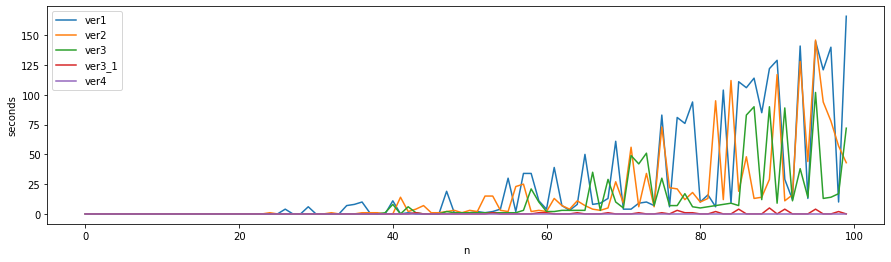

In [17]:
df_ver1 = pd.read_csv('./analysis/MinConflictsEngine_result.csv')
df_ver2 = pd.read_csv('./analysis/MinConflictsEngine_ver2_result.csv')
df_ver3 = pd.read_csv('./analysis/MinConflictsEngine_ver3_result.csv')
df_ver3_1 = pd.read_csv('./analysis/MinConflictsEngine_ver3_1_result.csv')
df_ver4 = pd.read_csv('./analysis/MinConflictsEngine_ver4_result.csv')

x = df_ver1.index

y1 = df_ver1['duration_seconds']
y2 = df_ver2['duration_seconds']
y3 = df_ver3['duration_seconds']
y3_1 = df_ver3_1['duration_seconds']
y4 = df_ver4['duration_seconds']

plt.figure(figsize=(15, 4))
plt.plot(x, y1, label='ver1')
plt.plot(x, y2, label='ver2')
plt.plot(x, y3, label='ver3')
plt.plot(x, y3_1, label='ver3_1')
plt.plot(x, y4, label='ver4')

plt.legend()
plt.xlabel('n')
plt.ylabel('seconds')
plt.show()